In [1]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [2]:
# 1) Install/configure Kaggle API
!pip install kaggle --quiet
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# 2) Download & unzip directly into ./ferplus_data
!kaggle datasets download -d msambare/fer2013 \
    -p ferplus_data \
    --unzip


Dataset URL: https://www.kaggle.com/datasets/msambare/fer2013
License(s): DbCL-1.0
 76% 46.0M/60.3M [00:00<00:00, 247MB/s]
100% 60.3M/60.3M [00:00<00:00, 251MB/s]


In [3]:
import numpy as np
import os
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, callbacks


In [4]:
train_dir = "/content/ferplus_data/train"
test_dir = "/content/ferplus_data/test"
emotion_labels = {
    0: 'angry', 1: 'disgust', 2: 'fear', 3: 'happy',
    4: 'sad', 5: 'surprise', 6: 'neutral'
}


In [5]:

import numpy as np

def manual_histogram_equalization(img):

    img = img.astype(np.uint8)
    h, w = img.shape


    hist = [0] * 256
    for y in range(h):
        for x in range(w):
            intensity = img[y, x]
            hist[intensity] += 1


    cdf = [0] * 256
    cdf[0] = hist[0]
    for i in range(1, 256):
        cdf[i] = cdf[i - 1] + hist[i]


    cdf_min = next(c for c in cdf if c > 0)


    total_pixels = h * w
    lut = [0] * 256
    for i in range(256):
        lut[i] = round((cdf[i] - cdf_min) / (total_pixels - cdf_min) * 255) if total_pixels > cdf_min else 0


    img_eq = np.zeros_like(img)
    for y in range(h):
        for x in range(w):
            img_eq[y, x] = lut[img[y, x]]

    return img_eq



In [6]:
def normalize(img):
    img_float = img.astype(np.float32)

    # Calculate percentiles instead of min/max to avoid outliers
    p_low, p_high = np.percentile(img_float, [5, 95])

    # Stretch the range
    img_normalized = np.clip((img_float - p_low) * 255.0 / (p_high - p_low), 0, 255)

    return img_normalized.astype(np.uint8)


In [7]:
def manual_sharpen(img, amount=None):
    if amount is None:
        variance = np.var(img)
        amount = min(1.0, max(0.2, variance / 5000))

    blur_kernel = np.array([[1, 2, 1],
                            [2, 4, 2],
                            [1, 2, 1]]) / 16.0

    img = img.astype(np.float32)
    padded = np.pad(img, ((1,1),(1,1)), mode='edge')
    blurred = np.zeros_like(img)

    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            region = padded[i:i+3, j:j+3]
            blurred[i, j] = np.sum(region * blur_kernel)

    sharpened = img + amount * (img - blurred)
    return np.clip(sharpened, 0, 255).astype(np.uint8)

In [8]:
!pip install PyWavelets


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 50.0 MB/s eta 0:00:00


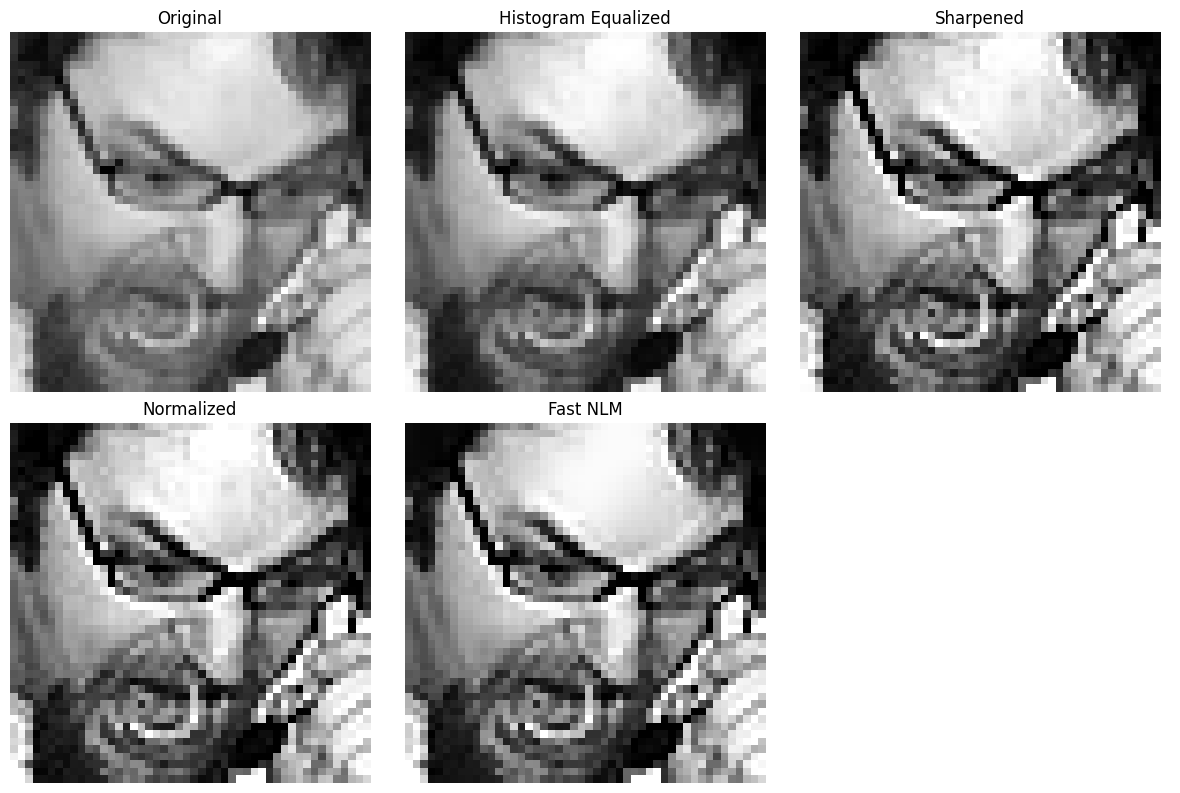

In [15]:
import cv2
import numpy as np
from skimage.restoration import denoise_wavelet

def preprocess_pipeline(img):
    img_eq = manual_histogram_equalization(img)
    img_sharp = manual_sharpen(img_eq, None)
    img_norm = normalize(img_sharp)

    img_fastnlm = cv2.fastNlMeansDenoising(img_norm, h=10)

    return img_eq, img_sharp, img_norm, img_fastnlm

import matplotlib.pyplot as plt
image_path = '/content/ferplus_data/test/angry/PrivateTest_10131363.jpg'


img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
original = img.copy()
img_eq, img_sharp, img_norm, img_fastnlm=preprocess_pipeline(img)

titles = [
    "Original", "Histogram Equalized", "Sharpened", "Normalized",
    "Fast NLM"
]

images = [
    original, img_eq, img_sharp, img_norm,
    img_fastnlm
]

fig, axes = plt.subplots(2, 3, figsize=(12, 8))
for i, (ax, title) in enumerate(zip(axes.flatten()[:len(images)], titles)):
    ax.imshow(images[i], cmap='gray')
    ax.set_title(title)
    ax.axis('off')

# Turn off any extra axes
for j in range(len(images), len(axes.flatten())):
    axes.flatten()[j].axis('off')


plt.tight_layout()
plt.show()


In [16]:
def apply_preprocessing(img):
    img_eq = manual_histogram_equalization(img)
    img_sharp = manual_sharpen(img_eq, None)
    img_norm = normalize(img_sharp)
    img_noise_reducrtion= cv2.fastNlMeansDenoising(img_norm, h=10)
    return img_noise_reducrtion


In [17]:
def load_data_with_preprocessing(folder):
    images = []
    labels = []
    for label_idx, emotion in emotion_labels.items():
        emotion_folder = os.path.join(folder, emotion)
        if not os.path.exists(emotion_folder):
            continue
        for img_name in os.listdir(emotion_folder):
            img_path = os.path.join(emotion_folder, img_name)
            img = tf.io.read_file(img_path)
            img = tf.image.decode_jpeg(img, channels=1)
            img = tf.image.resize(img, [48, 48])
            img = img.numpy().squeeze()
            img = apply_preprocessing(img)
            images.append(img)
            labels.append(label_idx)
    images = np.array(images)
    labels = np.array(labels)
    return images, labels


In [18]:
# Load

X_train, y_train = load_data_with_preprocessing(train_dir)
X_test, y_test = load_data_with_preprocessing(test_dir)
# Expand dims
X_train = np.expand_dims(X_train, -1)
X_test = np.expand_dims(X_test, -1)

# Train/Validation split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train, random_state=42)



"""y_train = to_categorical(y_train, num_classes=7)
y_val = to_categorical(y_val, num_classes=7)"""

print(X_train.shape, X_val.shape, X_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)



<ipython-input-6-de33e404d56b>:8: RuntimeWarning: invalid value encountered in divide
  img_normalized = np.clip((img_float - p_low) * 255.0 / (p_high - p_low), 0, 255)
<ipython-input-6-de33e404d56b>:10: RuntimeWarning: invalid value encountered in cast
  return img_normalized.astype(np.uint8)


(22967, 48, 48, 1) (5742, 48, 48, 1) (7178, 48, 48, 1)
(22967,) (5742,) (7178,)


In [19]:
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = dict(enumerate(class_weights))
print(class_weights_dict)


{0: 1.0265957446808511, 1: 9.401146131805158, 2: 1.0012206286237413, 3: 0.5684338184338185, 4: 0.849120082815735, 5: 1.2932597556168703, 6: 0.8260322255790534}


In [20]:
def build_cnn_model():
    model = models.Sequential([
        layers.Input(shape=(48, 48, 1)),

        layers.Conv2D(64, (3,3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3,3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2,2)),
        layers.Dropout(0.3),

        layers.Conv2D(128, (3,3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(128, (3,3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2,2)),
        layers.Dropout(0.4),

        layers.Conv2D(256, (3,3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(256, (3,3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2,2)),
        layers.Dropout(0.5),

        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),

        layers.Dense(7, activation='softmax')
    ])

    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model


In [21]:
early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

checkpoint = callbacks.ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)


In [25]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create an augmentation generator
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

# Fit the generator on your training data (optional but good for normalization-based generators)
datagen.fit(X_train)

# Build model
model = build_cnn_model()

# Train with generator
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=64),
    validation_data=(X_val, y_val),
    epochs=100,
    class_weight=class_weights_dict,
    callbacks=[early_stop, checkpoint]
)


Epoch 1/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 34s 63ms/step - accuracy: 0.1675 - loss: 2.5344 - val_accuracy: 0.1696 - val_loss: 2.0213
Epoch 2/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 16s 43ms/step - accuracy: 0.2341 - loss: 1.9620 - val_accuracy: 0.1820 - val_loss: 2.3211
Epoch 3/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 15s 43ms/step - accuracy: 0.3067 - loss: 1.7851 - val_accuracy: 0.2830 - val_loss: 1.8648
Epoch 4/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 15s 42ms/step - accuracy: 0.3603 - loss: 1.6368 - val_accuracy: 0.4190 - val_loss: 1.4980
Epoch 5/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 20s 42ms/step - accuracy: 0.3997 - loss: 1.5576 - val_accuracy: 0.4056 - val_loss: 1.6681
Epoch 6/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 15s 42ms/step - accuracy: 0.4342 - loss: 1.4763 - val_accuracy: 0.4639 - val_loss: 1.3970
Epoch 7/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 15s 42ms/step - accuracy: 0.4418 - loss: 1.4700 - val_accuracy: 0.4707 - val_loss: 1.3822
Epoch 8/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 15s 41ms/step - accuracy: 0.4369 - loss: 1

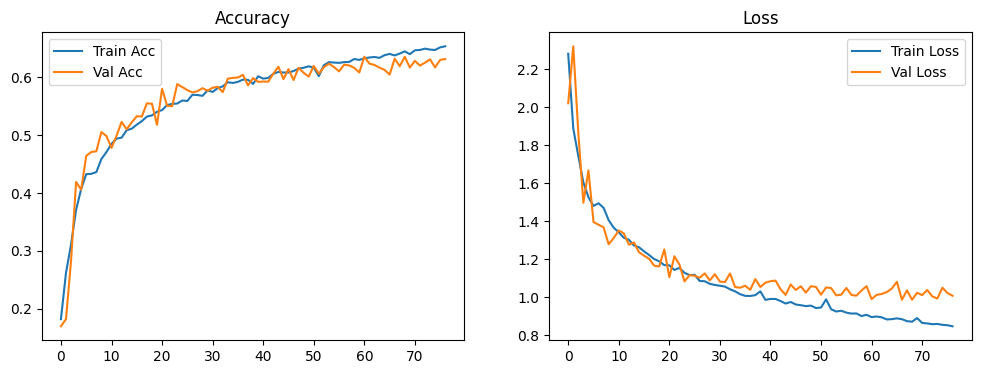

225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.5981 - loss: 1.0797
[0.9942970871925354, 0.6351351141929626]


In [26]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.title('Accuracy')

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss')

plt.show()
print(model.evaluate(X_test, y_test))

In [27]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc*100:.2f}%")

225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.5981 - loss: 1.0797
Test Accuracy: 63.51%


In [28]:
!pip install ultralytics

import cv2
import numpy as np
from ultralytics import YOLO
from tensorflow.keras.models import load_model


yolo_model = YOLO("/content/face_yolov8n.pt")
emotion_model = load_model("best_model.keras")

emotion_labels = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 27.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 116.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 94.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 61.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 108.9 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstallin

In [29]:
from google.colab.patches import cv2_imshow

def detect_and_predict_emotions(image_path):
    image = cv2.imread(image_path)
    results = yolo_model(image)

    for result in results:
        for box in result.boxes:
            x1, y1, x2, y2 = map(int, box.xyxy[0])
            face = image[y1:y2, x1:x2]
            if face.size == 0:
                continue

            gray = cv2.cvtColor(face, cv2.COLOR_BGR2GRAY)
            resized = cv2.resize(gray, (48, 48))
            processed = apply_preprocessing(resized)

            input_face = np.expand_dims(processed, axis=(0, -1))
            prediction = emotion_model.predict(input_face)
            emotion = emotion_labels[np.argmax(prediction)]

            cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
            cv2.putText(image, emotion, (x1, y1 - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)

    cv2_imshow(image)



0: 640x416 1 face, 67.8ms
Speed: 24.5ms preprocess, 67.8ms inference, 360.3ms postprocess per image at shape (1, 3, 640, 416)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


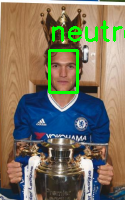

In [30]:

detect_and_predict_emotions("/content/Screenshot 2024-12-23 171035.png")


0: 512x640 1 face, 66.0ms
Speed: 4.9ms preprocess, 66.0ms inference, 2.6ms postprocess per image at shape (1, 3, 512, 640)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


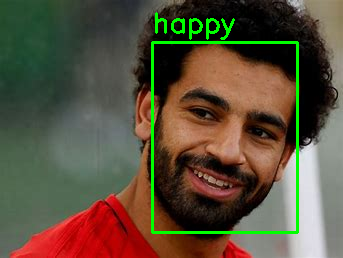

In [31]:
detect_and_predict_emotions("/content/OIP (2).jpeg")


0: 448x640 2 faces, 42.6ms
Speed: 3.5ms preprocess, 42.6ms inference, 2.1ms postprocess per image at shape (1, 3, 448, 640)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


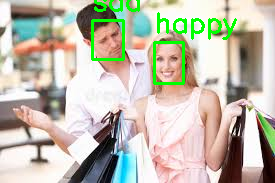

In [32]:
detect_and_predict_emotions("/content/images (7).jpeg")


0: 448x640 1 face, 9.8ms
Speed: 3.4ms preprocess, 9.8ms inference, 1.6ms postprocess per image at shape (1, 3, 448, 640)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


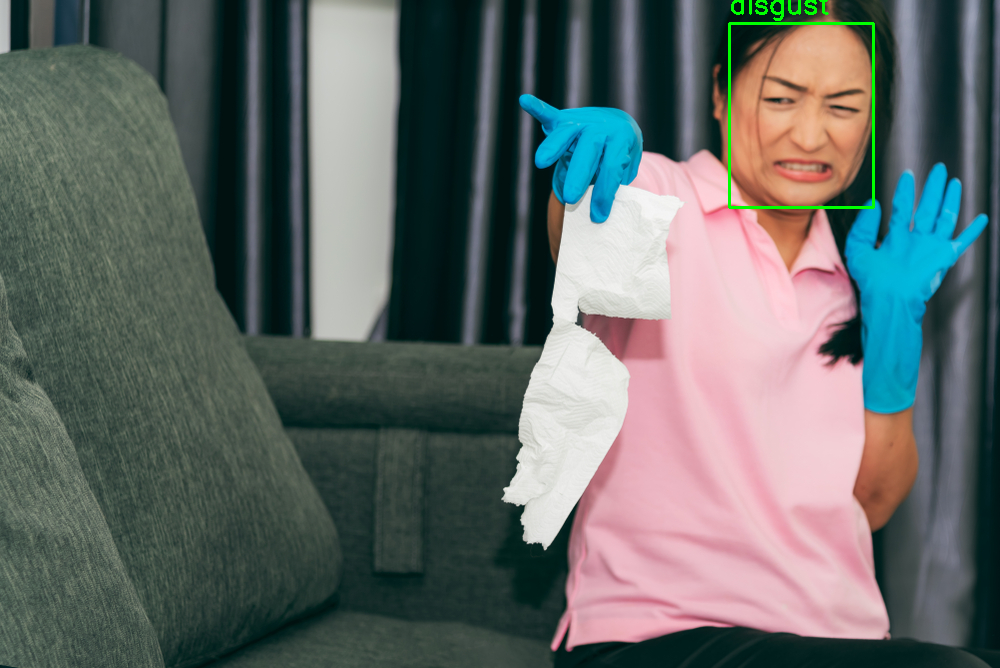

In [36]:
detect_and_predict_emotions("/content/shutterstock_1405622927.jpg")


0: 416x640 2 faces, 42.7ms
Speed: 2.6ms preprocess, 42.7ms inference, 1.6ms postprocess per image at shape (1, 3, 416, 640)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


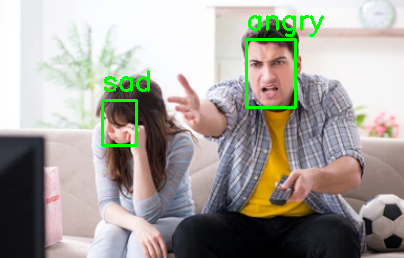

In [37]:
detect_and_predict_emotions("/content/Screenshot 2025-05-08 231026.png")

Saving Screenshot 2025-05-08 233159.png to Screenshot 2025-05-08 233159.png

0: 416x640 2 faces, 9.1ms
Speed: 2.6ms preprocess, 9.1ms inference, 1.6ms postprocess per image at shape (1, 3, 416, 640)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


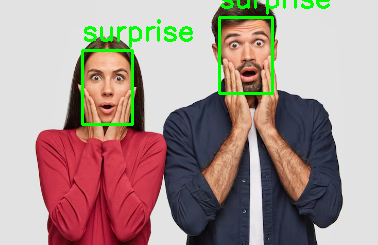

In [38]:
from google.colab import files
from google.colab.patches import cv2_imshow
import cv2
import numpy as np

uploaded = files.upload()

for filename in uploaded.keys():
    image_path = filename
    break

def detect_and_predict_emotions(image_path):
    image = cv2.imread(image_path)
    results = yolo_model(image)

    for result in results:
        for box in result.boxes:
            x1, y1, x2, y2 = map(int, box.xyxy[0])
            face = image[y1:y2, x1:x2]
            if face.size == 0:
                continue

            gray = cv2.cvtColor(face, cv2.COLOR_BGR2GRAY)
            resized = cv2.resize(gray, (48, 48))
            processed = apply_preprocessing(resized)

            input_face = np.expand_dims(processed, axis=(0, -1))
            prediction = emotion_model.predict(input_face)
            emotion = emotion_labels[np.argmax(prediction)]

            cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
            cv2.putText(image, emotion, (x1, y1 - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)

    cv2_imshow(image)

detect_and_predict_emotions(image_path)


In [39]:
!pip install gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.1/54.1 MB 20.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.9/322.9 kB 24.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 119.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 6.5 MB/s eta 0:00:00


In [41]:
import gradio as gr
from PIL import Image
import cv2
import numpy as np
import cv2

In [42]:

def detect_and_predict_emotions_gradio(img):
    img = np.array(img)
    img = img[:, :, ::-1].copy()

    results = yolo_model(img)
    for result in results:
        for box in result.boxes:
            x1, y1, x2, y2 = map(int, box.xyxy[0])
            face = img[y1:y2, x1:x2]
            if face.size == 0:
                continue
            gray = cv2.cvtColor(face, cv2.COLOR_BGR2GRAY)
            resized = cv2.resize(gray, (48, 48))
            processed = apply_preprocessing(resized)
            input_face = np.expand_dims(processed, axis=(0, -1))
            prediction = emotion_model.predict(input_face)
            emotion = emotion_labels[np.argmax(prediction)]
            cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
            cv2.putText(img, emotion, (x1, y1 - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return Image.fromarray(img)

gr.Interface(
    fn=detect_and_predict_emotions_gradio,
    inputs=gr.Image(type="pil"),
    outputs=gr.Image(type="pil"),
    title="Facial Emotion Recognition",
    description="Upload a face image. The app detects faces and predicts emotions."
).launch(share=True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://583b3e5818a2f42f3e.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
